<a href="https://colab.research.google.com/github/amar-naik/EVA/blob/master/S6/S6_step6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Team :
krishnateja.k2@gmail.com
amar.r.naik@gmail.com
shankar.uday007@gmail.com
prasad.shripathi@gmail.com

#Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
#defining the network structure
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05), # output_size = 26
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05), # output_size = 24
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(0.05),# output_size = 22
            nn.MaxPool2d(2, 2)# output_size = 11
            
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05)# output_size = 11

        ) 
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),# output_size = 9
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(0.05)# output_size = 7
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),#output_size = 5
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(0.05),# output_size = 5
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False)
            
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
      
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 10, 24, 24]             900
       BatchNorm2d-6           [-1, 10, 24, 24]              20
              ReLU-7           [-1, 10, 24, 24]               0
           Dropout-8           [-1, 10, 24, 24]               0
            Conv2d-9           [-1, 20, 22, 22]           1,800
      BatchNorm2d-10           [-1, 20, 22, 22]              40
             ReLU-11           [-1, 20, 22, 22]               0
          Dropout-12           [-1, 20, 22, 22]               0
        MaxPool2d-13           [-1, 20, 11, 11]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

#def train(model, device, train_loader, optimizer, epoch):
def train(model, device, train_loader, optimizer, epoch, L1_check = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  train_acc = []
  train_losses = []
   
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if(L1_check == True):
      l1_crit = nn.L1Loss(size_average = False)
      reg_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param)*0
        reg_loss +=l1_crit(param,zero_vector)
      factor = 0.0005
      loss += factor * reg_loss
    
    #train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
  train_losses.append(loss)
  train_acc.append(100*correct/processed)
  return train_losses, train_acc

def test(model, device, test_loader):
    #figsize=(15,10)
    model.eval()
    test_loss = 0
    correct = 0
    test_acc = []
    test_losses = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_acc

In [10]:
# Normal Run without L1 and L2

model =  Net().to(device).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
#inputs, labels = inputs.to(device), labels.to(device)
N_Train_Loss = []
N_Train_Accu = []
N_Test_Loss = []
N_Test_Accu =[]

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    #train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    #test(model, device, test_loader)
    N_Train_Losst, N_Train_Accut = train(model, device, train_loader, optimizer, epoch, L1_check = False) 
    N_Train_Loss.append(N_Train_Losst) 
    N_Train_Accu.append(N_Train_Accut)
    N_Test_Losst, N_Test_Accut = test(model, device, test_loader)
    N_Test_Loss.append(N_Test_Losst)
    N_Test_Accu.append(N_Test_Accut)


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.03427843749523163 Batch_id=468 Accuracy=91.42: 100%|██████████| 469/469 [00:15<00:00, 30.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9812/10000 (98.12%)

EPOCH: 1


Loss=0.01870427466928959 Batch_id=468 Accuracy=97.40: 100%|██████████| 469/469 [00:15<00:00, 31.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9880/10000 (98.80%)

EPOCH: 2


Loss=0.06287115067243576 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:15<00:00, 30.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0349, Accuracy: 9893/10000 (98.93%)

EPOCH: 3


Loss=0.06585349887609482 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:15<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0347, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.016835803166031837 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:14<00:00, 31.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9897/10000 (98.97%)

EPOCH: 5


Loss=0.06428243964910507 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:15<00:00, 31.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9915/10000 (99.15%)

EPOCH: 6


Loss=0.03788679465651512 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.010415762662887573 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.05773283541202545 Batch_id=468 Accuracy=98.65: 100%|██████████| 469/469 [00:15<00:00, 30.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.01614200510084629 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9917/10000 (99.17%)

EPOCH: 10


Loss=0.007240454200655222 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9924/10000 (99.24%)

EPOCH: 11


Loss=0.006267338991165161 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.17991821467876434 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.08758632093667984 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)

EPOCH: 14


Loss=0.010910461656749249 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:15<00:00, 29.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.020592620596289635 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.019630679860711098 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9933/10000 (99.33%)

EPOCH: 17


Loss=0.019043555483222008 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9934/10000 (99.34%)

EPOCH: 18


Loss=0.04067464545369148 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:16<00:00, 28.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.0033690035343170166 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9943/10000 (99.43%)

EPOCH: 20


Loss=0.01177053153514862 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:15<00:00, 29.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.018520742654800415 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:15<00:00, 29.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9933/10000 (99.33%)

EPOCH: 22


Loss=0.05923318862915039 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 29.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9945/10000 (99.45%)

EPOCH: 23


Loss=0.11308405548334122 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:15<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)

EPOCH: 24


Loss=0.004749894142150879 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0174, Accuracy: 9940/10000 (99.40%)

EPOCH: 25


Loss=0.07045773416757584 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH: 26


Loss=0.006433913949877024 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:16<00:00, 28.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 27


Loss=0.003275762079283595 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9927/10000 (99.27%)

EPOCH: 28


Loss=0.021001333370804787 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9923/10000 (99.23%)

EPOCH: 29


Loss=0.046703264117240906 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:16<00:00, 29.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

EPOCH: 30


Loss=0.012450496666133404 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0176, Accuracy: 9949/10000 (99.49%)

EPOCH: 31


Loss=0.002339676022529602 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9932/10000 (99.32%)

EPOCH: 32


Loss=0.0519893504679203 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:16<00:00, 28.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.45%)

EPOCH: 33


Loss=0.007680326700210571 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9934/10000 (99.34%)

EPOCH: 34


Loss=0.03601168468594551 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)

EPOCH: 35


Loss=0.03617987409234047 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9945/10000 (99.45%)

EPOCH: 36


Loss=0.0022332866210490465 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)

EPOCH: 37


Loss=0.017701417207717896 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


Loss=0.002079020021483302 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9941/10000 (99.41%)

EPOCH: 39


Loss=0.0004473427834454924 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]



Test set: Average loss: 0.0183, Accuracy: 9941/10000 (99.41%)



In [11]:
# L1 Run

model =  Net().to(device).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
#inputs, labels = inputs.to(device), labels.to(device)
L1_Train_Loss = []
L1_Train_Accu = []
L1_Test_Loss = []
L1_Test_Accu =[]

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    #train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    #test(model, device, test_loader)
    L1_Train_Losst, L1_Train_Accut = train(model, device, train_loader, optimizer, epoch, L1_check = True) 
    L1_Train_Loss.append(L1_Train_Losst) 
    L1_Train_Accu.append(L1_Train_Accut)
    L1_Test_Losst, L1_Test_Accut = test(model, device, test_loader)
    L1_Test_Loss.append(L1_Test_Losst)
    L1_Test_Accu.append(L1_Test_Accut)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.39148616790771484 Batch_id=468 Accuracy=90.28: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0713, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.35387057065963745 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0681, Accuracy: 9771/10000 (97.71%)

EPOCH: 2


Loss=0.3752940893173218 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:19<00:00, 24.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9835/10000 (98.35%)

EPOCH: 3


Loss=0.2785472571849823 Batch_id=468 Accuracy=97.39: 100%|██████████| 469/469 [00:18<00:00, 24.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0536, Accuracy: 9830/10000 (98.30%)

EPOCH: 4


Loss=0.2956521809101105 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:18<00:00, 31.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9783/10000 (97.83%)

EPOCH: 5


Loss=0.20796425640583038 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:18<00:00, 24.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0537, Accuracy: 9830/10000 (98.30%)

EPOCH: 6


Loss=0.21338249742984772 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:18<00:00, 24.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0523, Accuracy: 9829/10000 (98.29%)

EPOCH: 7


Loss=0.308887779712677 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0466, Accuracy: 9837/10000 (98.37%)

EPOCH: 8


Loss=0.2510899603366852 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:18<00:00, 25.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0600, Accuracy: 9812/10000 (98.12%)

EPOCH: 9


Loss=0.20931057631969452 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0566, Accuracy: 9814/10000 (98.14%)

EPOCH: 10


Loss=0.29802751541137695 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:18<00:00, 31.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9790/10000 (97.90%)

EPOCH: 11


Loss=0.27258196473121643 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0593, Accuracy: 9802/10000 (98.02%)

EPOCH: 12


Loss=0.20064295828342438 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:18<00:00, 31.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9849/10000 (98.49%)

EPOCH: 13


Loss=0.23145943880081177 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:18<00:00, 24.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0598, Accuracy: 9820/10000 (98.20%)

EPOCH: 14


Loss=0.24854254722595215 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:18<00:00, 24.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0551, Accuracy: 9815/10000 (98.15%)

EPOCH: 15


Loss=0.18628433346748352 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:18<00:00, 25.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0482, Accuracy: 9852/10000 (98.52%)

EPOCH: 16


Loss=0.23992371559143066 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:18<00:00, 25.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9802/10000 (98.02%)

EPOCH: 17


Loss=0.2476172298192978 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0470, Accuracy: 9843/10000 (98.43%)

EPOCH: 18


Loss=0.20261818170547485 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9849/10000 (98.49%)

EPOCH: 19


Loss=0.20490851998329163 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:18<00:00, 25.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0611, Accuracy: 9805/10000 (98.05%)

EPOCH: 20


Loss=0.14805279672145844 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0590, Accuracy: 9812/10000 (98.12%)

EPOCH: 21


Loss=0.18382211029529572 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:18<00:00, 30.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9872/10000 (98.72%)

EPOCH: 22


Loss=0.23296096920967102 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:18<00:00, 32.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9849/10000 (98.49%)

EPOCH: 23


Loss=0.19765393435955048 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0547, Accuracy: 9824/10000 (98.24%)

EPOCH: 24


Loss=0.15798987448215485 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:18<00:00, 30.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9832/10000 (98.32%)

EPOCH: 25


Loss=0.26917943358421326 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:17<00:00, 31.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0649, Accuracy: 9798/10000 (97.98%)

EPOCH: 26


Loss=0.20808476209640503 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:18<00:00, 25.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9854/10000 (98.54%)

EPOCH: 27


Loss=0.23173868656158447 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0476, Accuracy: 9836/10000 (98.36%)

EPOCH: 28


Loss=0.1615009903907776 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:18<00:00, 25.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0454, Accuracy: 9861/10000 (98.61%)

EPOCH: 29


Loss=0.1699257642030716 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:18<00:00, 25.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9865/10000 (98.65%)

EPOCH: 30


Loss=0.1535188853740692 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:18<00:00, 25.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Accuracy: 9850/10000 (98.50%)

EPOCH: 31


Loss=0.14768177270889282 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:18<00:00, 25.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0429, Accuracy: 9871/10000 (98.71%)

EPOCH: 32


Loss=0.23298713564872742 Batch_id=468 Accuracy=97.64: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0545, Accuracy: 9834/10000 (98.34%)

EPOCH: 33


Loss=0.2190619707107544 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:17<00:00, 26.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0507, Accuracy: 9832/10000 (98.32%)

EPOCH: 34


Loss=0.22962133586406708 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:17<00:00, 26.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0463, Accuracy: 9851/10000 (98.51%)

EPOCH: 35


Loss=0.16143101453781128 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0426, Accuracy: 9875/10000 (98.75%)

EPOCH: 36


Loss=0.16143003106117249 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:17<00:00, 26.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0668, Accuracy: 9782/10000 (97.82%)

EPOCH: 37


Loss=0.19874462485313416 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9864/10000 (98.64%)

EPOCH: 38


Loss=0.17776596546173096 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0550, Accuracy: 9826/10000 (98.26%)

EPOCH: 39


Loss=0.16593877971172333 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:17<00:00, 26.22it/s]



Test set: Average loss: 0.0656, Accuracy: 9789/10000 (97.89%)



In [12]:
# L2 Run

model =  Net().to(device).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95,weight_decay = 0.01)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
#inputs, labels = inputs.to(device), labels.to(device)
L2_Train_Loss = []
L2_Train_Accu = []
L2_Test_Loss = []
L2_Test_Accu =[]

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    #train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    #test(model, device, test_loader)
    L2_Train_Losst, L2_Train_Accut = train(model, device, train_loader, optimizer, epoch, L1_check = False) 
    L2_Train_Loss.append(L2_Train_Losst) 
    L2_Train_Accu.append(L2_Train_Accut)
    L2_Test_Losst, L2_Test_Accut = test(model, device, test_loader)
    L2_Test_Loss.append(L2_Test_Losst)
    L2_Test_Accu.append(L2_Test_Accut)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.07330266386270523 Batch_id=468 Accuracy=92.45: 100%|██████████| 469/469 [00:15<00:00, 29.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0836, Accuracy: 9788/10000 (97.88%)

EPOCH: 1


Loss=0.10161063820123672 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:15<00:00, 29.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0971, Accuracy: 9777/10000 (97.77%)

EPOCH: 2


Loss=0.03137833997607231 Batch_id=468 Accuracy=97.37: 100%|██████████| 469/469 [00:15<00:00, 29.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0707, Accuracy: 9813/10000 (98.13%)

EPOCH: 3


Loss=0.11981170624494553 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:16<00:00, 28.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0712, Accuracy: 9787/10000 (97.87%)

EPOCH: 4


Loss=0.10055097192525864 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:15<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0716, Accuracy: 9801/10000 (98.01%)

EPOCH: 5


Loss=0.0602840818464756 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9813/10000 (98.13%)

EPOCH: 6


Loss=0.0640464797616005 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:15<00:00, 30.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0676, Accuracy: 9801/10000 (98.01%)

EPOCH: 7


Loss=0.1307360678911209 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 30.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1015, Accuracy: 9712/10000 (97.12%)

EPOCH: 8


Loss=0.1932573765516281 Batch_id=468 Accuracy=97.74: 100%|██████████| 469/469 [00:15<00:00, 30.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9825/10000 (98.25%)

EPOCH: 9


Loss=0.05263886973261833 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 30.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9833/10000 (98.33%)

EPOCH: 10


Loss=0.03623165562748909 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 29.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0617, Accuracy: 9839/10000 (98.39%)

EPOCH: 11


Loss=0.1015876904129982 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 29.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0543, Accuracy: 9856/10000 (98.56%)

EPOCH: 12


Loss=0.06909697502851486 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:15<00:00, 30.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9843/10000 (98.43%)

EPOCH: 13


Loss=0.024945655837655067 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:15<00:00, 34.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0522, Accuracy: 9860/10000 (98.60%)

EPOCH: 14


Loss=0.10349062830209732 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9810/10000 (98.10%)

EPOCH: 15


Loss=0.048825740814208984 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0541, Accuracy: 9861/10000 (98.61%)

EPOCH: 16


Loss=0.09295500069856644 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0936, Accuracy: 9728/10000 (97.28%)

EPOCH: 17


Loss=0.04298825189471245 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0565, Accuracy: 9861/10000 (98.61%)

EPOCH: 18


Loss=0.08606645464897156 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:15<00:00, 29.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Accuracy: 9738/10000 (97.38%)

EPOCH: 19


Loss=0.11128824949264526 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:15<00:00, 30.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9836/10000 (98.36%)

EPOCH: 20


Loss=0.0834076777100563 Batch_id=468 Accuracy=97.85: 100%|██████████| 469/469 [00:15<00:00, 30.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0920, Accuracy: 9730/10000 (97.30%)

EPOCH: 21


Loss=0.07660416513681412 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:15<00:00, 30.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Accuracy: 9793/10000 (97.93%)

EPOCH: 22


Loss=0.03257318213582039 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0660, Accuracy: 9825/10000 (98.25%)

EPOCH: 23


Loss=0.0742206946015358 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 29.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0628, Accuracy: 9824/10000 (98.24%)

EPOCH: 24


Loss=0.049480948597192764 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:15<00:00, 30.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9865/10000 (98.65%)

EPOCH: 25


Loss=0.12589280307292938 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:15<00:00, 29.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9822/10000 (98.22%)

EPOCH: 26


Loss=0.08701469749212265 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:15<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0817, Accuracy: 9759/10000 (97.59%)

EPOCH: 27


Loss=0.047820836305618286 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 30.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9850/10000 (98.50%)

EPOCH: 28


Loss=0.06836395710706711 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0582, Accuracy: 9860/10000 (98.60%)

EPOCH: 29


Loss=0.08074326068162918 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:15<00:00, 30.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0779, Accuracy: 9779/10000 (97.79%)

EPOCH: 30


Loss=0.13851362466812134 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:15<00:00, 30.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9861/10000 (98.61%)

EPOCH: 31


Loss=0.06676096469163895 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:15<00:00, 30.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1029, Accuracy: 9717/10000 (97.17%)

EPOCH: 32


Loss=0.04271363094449043 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:15<00:00, 29.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0750, Accuracy: 9824/10000 (98.24%)

EPOCH: 33


Loss=0.05845347046852112 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9841/10000 (98.41%)

EPOCH: 34


Loss=0.050867002457380295 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:15<00:00, 30.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0653, Accuracy: 9834/10000 (98.34%)

EPOCH: 35


Loss=0.043685127049684525 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:15<00:00, 30.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0684, Accuracy: 9815/10000 (98.15%)

EPOCH: 36


Loss=0.11948796361684799 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:15<00:00, 30.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0679, Accuracy: 9831/10000 (98.31%)

EPOCH: 37


Loss=0.13343305885791779 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:15<00:00, 29.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0808, Accuracy: 9779/10000 (97.79%)

EPOCH: 38


Loss=0.05737476050853729 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:15<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0583, Accuracy: 9866/10000 (98.66%)

EPOCH: 39


Loss=0.1028263196349144 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:15<00:00, 29.50it/s]



Test set: Average loss: 0.0643, Accuracy: 9820/10000 (98.20%)



In [13]:
# L1L2 Run
model =  Net().to(device).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95,weight_decay = 0.01)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
#inputs, labels = inputs.to(device), labels.to(device)
L1L2_Train_Loss = []
L1L2_Train_Accu = []
L1L2_Test_Loss = []
L1L2_Test_Accu =[]

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    #train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    #test(model, device, test_loader)
    L1L2_Train_Losst, L1L2_Train_Accut = train(model, device, train_loader, optimizer, epoch, L1_check = True) 
    L1L2_Train_Loss.append(L1L2_Train_Losst) 
    L1L2_Train_Accu.append(L1L2_Train_Accut)
    L1L2_Test_Losst, L1L2_Test_Accut = test(model, device, test_loader)
    L1L2_Test_Loss.append(L1L2_Test_Losst)
    L1L2_Test_Accu.append(L1L2_Test_Accut)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=0.3070230484008789 Batch_id=468 Accuracy=91.83: 100%|██████████| 469/469 [00:17<00:00, 26.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1271, Accuracy: 9750/10000 (97.50%)

EPOCH: 1


Loss=0.2557860314846039 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:17<00:00, 26.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0859, Accuracy: 9809/10000 (98.09%)

EPOCH: 2


Loss=0.23594486713409424 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0956, Accuracy: 9771/10000 (97.71%)

EPOCH: 3


Loss=0.18674930930137634 Batch_id=468 Accuracy=96.95: 100%|██████████| 469/469 [00:17<00:00, 26.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1258, Accuracy: 9667/10000 (96.67%)

EPOCH: 4


Loss=0.20249977707862854 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:17<00:00, 26.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1976, Accuracy: 9399/10000 (93.99%)

EPOCH: 5


Loss=0.1891949623823166 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:17<00:00, 26.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1466, Accuracy: 9577/10000 (95.77%)

EPOCH: 6


Loss=0.21791696548461914 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:17<00:00, 26.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0869, Accuracy: 9750/10000 (97.50%)

EPOCH: 7


Loss=0.22500503063201904 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:17<00:00, 26.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0749, Accuracy: 9808/10000 (98.08%)

EPOCH: 8


Loss=0.18635880947113037 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:18<00:00, 31.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1059, Accuracy: 9714/10000 (97.14%)

EPOCH: 9


Loss=0.16584940254688263 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:19<00:00, 30.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0868, Accuracy: 9772/10000 (97.72%)

EPOCH: 10


Loss=0.1695067584514618 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:19<00:00, 24.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0770, Accuracy: 9798/10000 (97.98%)

EPOCH: 11


Loss=0.23778793215751648 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:18<00:00, 25.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0899, Accuracy: 9738/10000 (97.38%)

EPOCH: 12


Loss=0.17671066522598267 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1923, Accuracy: 9454/10000 (94.54%)

EPOCH: 13


Loss=0.2141052484512329 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:18<00:00, 25.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0860, Accuracy: 9753/10000 (97.53%)

EPOCH: 14


Loss=0.16864489018917084 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:18<00:00, 25.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0933, Accuracy: 9752/10000 (97.52%)

EPOCH: 15


Loss=0.20341116189956665 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:18<00:00, 25.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0845, Accuracy: 9760/10000 (97.60%)

EPOCH: 16


Loss=0.21222996711730957 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1001, Accuracy: 9729/10000 (97.29%)

EPOCH: 17


Loss=0.2225314974784851 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:18<00:00, 25.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1239, Accuracy: 9671/10000 (96.71%)

EPOCH: 18


Loss=0.18344974517822266 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:18<00:00, 25.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1239, Accuracy: 9689/10000 (96.89%)

EPOCH: 19


Loss=0.18673107028007507 Batch_id=468 Accuracy=97.11: 100%|██████████| 469/469 [00:18<00:00, 30.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1151, Accuracy: 9664/10000 (96.64%)

EPOCH: 20


Loss=0.26534897089004517 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:18<00:00, 25.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1242, Accuracy: 9649/10000 (96.49%)

EPOCH: 21


Loss=0.19426557421684265 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:18<00:00, 31.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0873, Accuracy: 9747/10000 (97.47%)

EPOCH: 22


Loss=0.1779126524925232 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:18<00:00, 25.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1088, Accuracy: 9754/10000 (97.54%)

EPOCH: 23


Loss=0.34556692838668823 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:18<00:00, 25.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0877, Accuracy: 9755/10000 (97.55%)

EPOCH: 24


Loss=0.21208009123802185 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:18<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0942, Accuracy: 9733/10000 (97.33%)

EPOCH: 25


Loss=0.23556029796600342 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:18<00:00, 25.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1021, Accuracy: 9708/10000 (97.08%)

EPOCH: 26


Loss=0.14882677793502808 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:18<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1938, Accuracy: 9528/10000 (95.28%)

EPOCH: 27


Loss=0.17987021803855896 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:18<00:00, 25.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0864, Accuracy: 9804/10000 (98.04%)

EPOCH: 28


Loss=0.26107195019721985 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:18<00:00, 30.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0804, Accuracy: 9810/10000 (98.10%)

EPOCH: 29


Loss=0.222001314163208 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:18<00:00, 25.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9818/10000 (98.18%)

EPOCH: 30


Loss=0.26689478754997253 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:17<00:00, 26.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0753, Accuracy: 9810/10000 (98.10%)

EPOCH: 31


Loss=0.24300600588321686 Batch_id=468 Accuracy=97.09: 100%|██████████| 469/469 [00:18<00:00, 25.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1378, Accuracy: 9637/10000 (96.37%)

EPOCH: 32


Loss=0.1964159607887268 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:17<00:00, 31.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0755, Accuracy: 9811/10000 (98.11%)

EPOCH: 33


Loss=0.1833515614271164 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:17<00:00, 26.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 9737/10000 (97.37%)

EPOCH: 34


Loss=0.18063819408416748 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:17<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0922, Accuracy: 9776/10000 (97.76%)

EPOCH: 35


Loss=0.20299676060676575 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0956, Accuracy: 9727/10000 (97.27%)

EPOCH: 36


Loss=0.2671893239021301 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:17<00:00, 27.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1390, Accuracy: 9569/10000 (95.69%)

EPOCH: 37


Loss=0.1875375211238861 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:17<00:00, 27.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0861, Accuracy: 9734/10000 (97.34%)

EPOCH: 38


Loss=0.19084542989730835 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0969, Accuracy: 9728/10000 (97.28%)

EPOCH: 39


Loss=0.22192847728729248 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:18<00:00, 25.51it/s]



Test set: Average loss: 0.1983, Accuracy: 9539/10000 (95.39%)



Printing Graphs

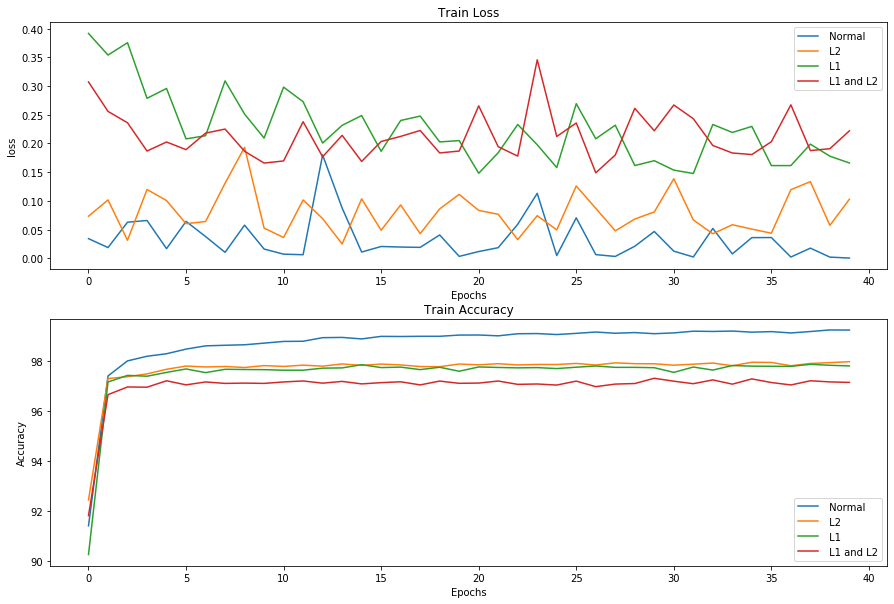

In [16]:
import matplotlib.pyplot as plt

fig1, (axs3,axs4) = plt.subplots(2, 1,figsize=(15,10))

axs3.plot(N_Train_Loss, label = " Normal")
axs3.plot(L2_Train_Loss, label = " L2")
axs3.plot(L1_Train_Loss, label = " L1")
axs3.plot(L1L2_Train_Loss, label = " L1 and L2")
axs3.set_title("Train Loss")
axs3.set_xlabel("Epochs")
axs3.set_ylabel("loss")


axs4.plot(N_Train_Accu, label = " Normal")
axs4.plot(L2_Train_Accu, label = " L2")
axs4.plot(L1_Train_Accu, label = " L1")
axs4.plot(L1L2_Train_Accu, label = " L1 and L2")

axs4.set_title("Train Accuracy")
axs4.set_xlabel("Epochs")
axs4.set_ylabel("Accuracy")

axs3.legend()
axs4.legend()
plt.show()


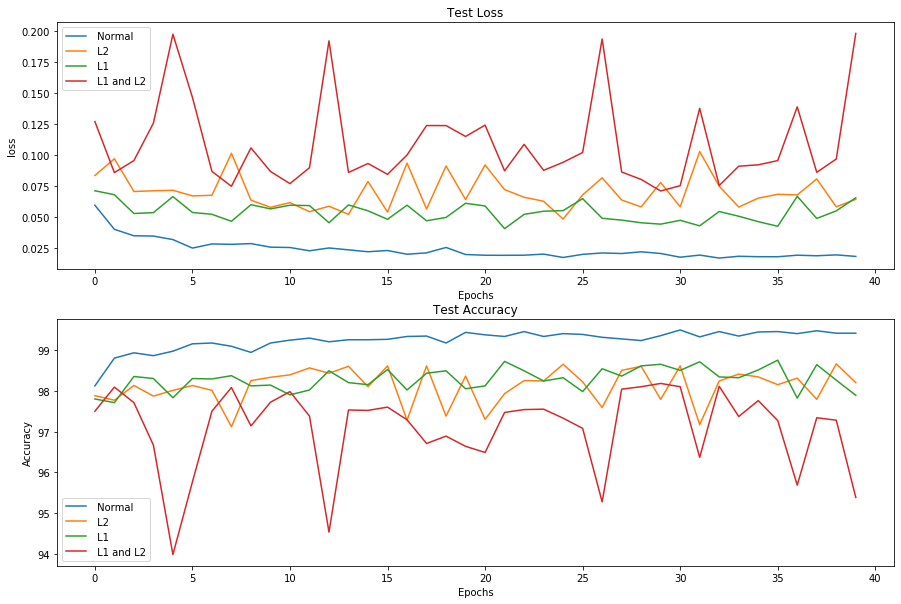

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (axs1,axs2) = plt.subplots(2, 1,figsize=(15,10))

axs1.plot(N_Test_Loss, label = " Normal")
axs1.plot(L2_Test_Loss, label = " L2")
axs1.plot(L1_Test_Loss, label = " L1")
axs1.plot(L1L2_Test_Loss, label = " L1 and L2")

axs1.set_title("Test Loss")
axs1.set_xlabel("Epochs")
axs1.set_ylabel("loss")


axs2.plot(N_Test_Accu, label = " Normal")
axs2.plot(L2_Test_Accu, label = " L2")
axs2.plot(L1_Test_Accu, label = " L1")
axs2.plot(L1L2_Test_Accu, label = " L1 and L2")

axs2.set_title("Test Accuracy")
axs2.set_xlabel("Epochs")
axs2.set_ylabel("Accuracy")

axs1.legend()
axs2.legend()
plt.show()

In [0]:
def get_Tstmisclassified_images(model, device, loader):
    model.eval()
    test_loss = 0
    correct = 0
    count = 0
    if epoch >=39:
      figure = plt.figure(figsize=(15,10))
      figure.suptitle('Test Data : Misclassification', fontsize=16)

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device)
    
            for index,image in enumerate(data):      
                if x[index] == 1 and count < 25 and epoch>=39:
                  plt.subplot(5, 5, count+1)
                  plt.axis('off')
                  plt.title("Classified as : "+ str(pred[index].item()))
                  plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
                  count = count+1   

    test_loss /= len(test_loader.dataset)


In [0]:
def get_Trnmisclassified_images(model, device, train_loader, optimizer, epoch, L1_check = False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  count = 0
  processed = 0
  train_acc = []
  train_losses = []
   
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if(L1_check == True):
      l1_crit = nn.L1Loss(size_average = False)
      reg_loss = 0
      for param in model.parameters():
        zero_vector = torch.rand_like(param)*0
        reg_loss +=l1_crit(param,zero_vector)
      factor = 0.0005
      loss += factor * reg_loss
    
    #train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    x = torch.tensor((~pred.eq(target.view_as(pred))), dtype=torch.float, device = device)
    
    for index,image in enumerate(data):      
        if x[index] == 1 and count < 25 and epoch>=39:
          plt.subplot(5, 5, count+1)
          plt.axis('off')
          plt.title("Classified as : "+ str(pred[index].item()))
          plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
          count = count+1        

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.38412144780158997 Batch_id=468 Accuracy=90.88: 100%|██████████| 469/469 [00:19<00:00, 24.01it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.2642787992954254 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:20<00:00, 22.56it/s]
Loss=0.24431124329566956 Batch_

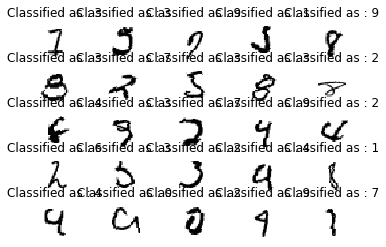

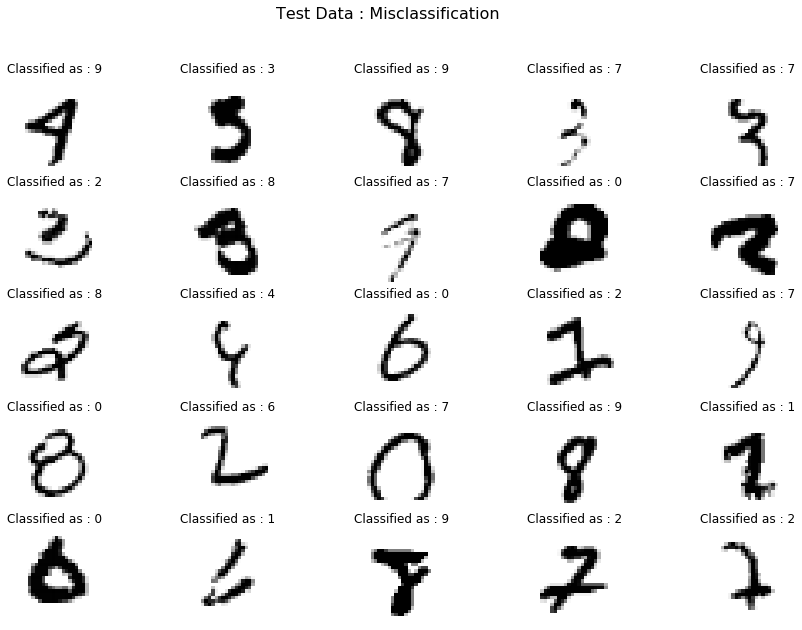

In [20]:
# L1 Run misclassified images

model =  Net().to(device).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
#inputs, labels = inputs.to(device), labels.to(device)

EPOCHS = 40
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    get_Trnmisclassified_images(model, device, train_loader, optimizer, epoch, L1_check = True) 
    get_Tstmisclassified_images(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.19722843170166016 Batch_id=468 Accuracy=90.50: 100%|██████████| 469/469 [00:18<00:00, 24.84it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
Loss=0.1168714091181755 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:18<00:00, 25.04it/s]
Loss=0.09810412675142288 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:18<00:00, 31.91it/s]
Loss=0.1078026294708252 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:19<00:00, 32.73it/s]
Loss=0.12551499903202057 

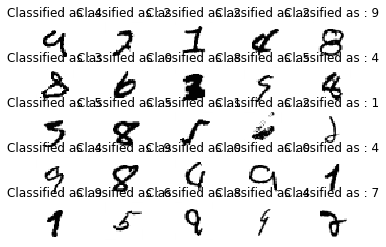

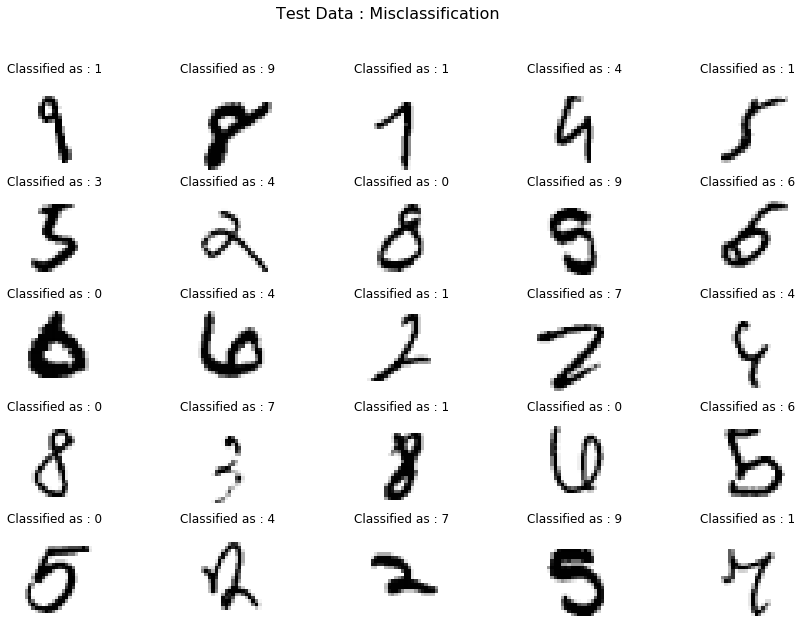

In [21]:
# L2 Run misclassified images

model =  Net().to(device).cuda()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95,weight_decay = 0.01)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
#inputs, labels = inputs.to(device), labels.to(device)

EPOCHS = 40
for epoch in range(EPOCHS):
    #print("EPOCH:", epoch)
    get_Trnmisclassified_images(model, device, train_loader, optimizer, epoch, L1_check = False) 
    get_Tstmisclassified_images(model, device, test_loader)